In [70]:
# load libraries
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

import nltk
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\groov\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [165]:
# load trump df
csv_file = r'C:\Users\groov\PythonCode\output\trump_tweets\trump_tweets.csv'

df = pd.read_csv(csv_file, names=['date_posted', 'tweet'])
df['tweet'] = df['tweet'].str.lower()
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)
df = df[~df['tweet'].str.startswith('rt')]
df = df[~df['tweet'].str.contains('http')]
df['date_posted'] = pd.to_datetime(df['date_posted'])
df.set_index('date_posted', inplace=True)
df = df.tz_convert('US/Eastern')
df.sort_index(inplace=True)

df.tail(5)

,tweet
date_posted,
2019-10-26 16:20:04-04:00,mississippi! there is a very important electio...
2019-10-26 16:20:04-04:00,he loves our military and supports our vets! d...
2019-10-26 16:26:34-04:00,governor @mattbevin has done a wonderful job f...
2019-10-26 16:26:34-04:00,"matt has my complete and total endorsement, an..."
2019-10-26 21:23:39-04:00,something very big has just happened!


In [166]:
# append semantic score
sa = SentimentIntensityAnalyzer()

compound_scores = []

for tweet in df['tweet']:
    compound_scores.append(sa.polarity_scores(tweet)['compound'])
    
df['compound_score'] = compound_scores

df.head()

,tweet,compound_score
date_posted,,
2019-10-09 08:14:02-04:00,the united states has spent eight trillion dol...,-0.8750
2019-10-09 08:14:03-04:00,in the history of our country! we went to war ...,-0.6776
2019-10-09 08:22:04-04:00,"the do nothing democrats are con artists, only...",-0.6209
2019-10-09 08:43:45-04:00,"the so-called whistleblower, before knowing i ...",-0.5411
2019-10-09 08:43:45-04:00,no pressure at all said ukraine! very congenia...,-0.5691


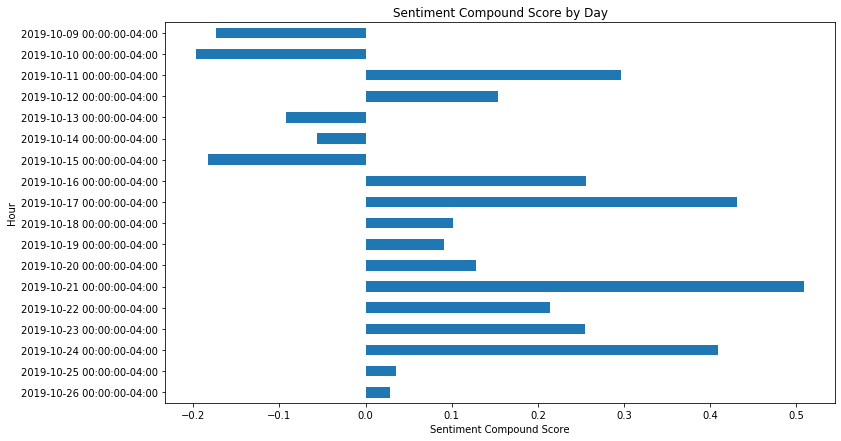

In [167]:
ax = df['compound_score'].resample('D').mean().plot.barh(figsize=(12, 7), title='Sentiment Compound Score by Day')
ax.set_xlabel('Sentiment Compound Score')
ax.set_ylabel('Hour')
plt.gca().invert_yaxis()

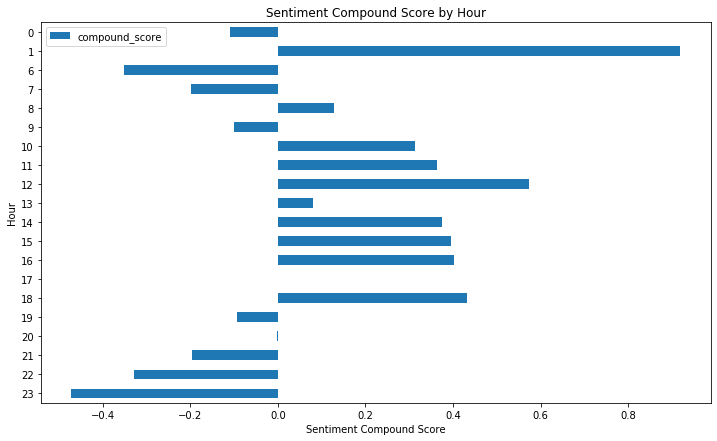

In [168]:
df['hour'] = df.index.hour

ax = df.groupby(['hour']).mean().plot.barh(figsize=(12, 7), title='Sentiment Compound Score by Hour')
ax.set_xlabel('Sentiment Compound Score')
ax.set_ylabel('Hour')
plt.gca().invert_yaxis()

In [169]:
# extract mean tweets
mean_df = df[df['compound_score'] <= -0.3][['tweet']]

In [170]:
# do page 127 from book

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize.casual import casual_tokenize

tfidf = TfidfVectorizer(tokenizer=casual_tokenize)
tfidf_docs = tfidf.fit_transform(raw_documents=df['tweet']).toarray()

len(tfidf.vocabulary_)

1781

In [171]:
tfidf_docs = pd.DataFrame(tfidf_docs)
tfidf_docs = tfidf_docs - tfidf_docs.mean() # center the vectorized documents
tfidf_docs.shape

(203, 1781)

In [246]:
# do pages 128+ from book

topic_count = 6

from sklearn.decomposition import PCA

pca = PCA(n_components=topic_count)
pca = pca.fit(tfidf_docs)

pca_topic_vectors = pca.transform(tfidf_docs)

In [247]:
columns = ['topic{}'.format(i) for i in range(pca.n_components)]

In [248]:
pca_topic_vectors = pd.DataFrame(pca_topic_vectors, columns=columns)

In [249]:
pca_topic_vectors.head(10)

,topic0,topic1,topic2,topic3,topic4,topic5
0,-0.072578,-0.157393,0.197189,0.126712,-0.046494,-0.010647
1,-0.111470,-0.071913,-0.000470,0.045380,0.060539,-0.087880
2,-0.053956,-0.073615,-0.241654,0.052934,0.161028,-0.073965
3,0.118234,0.002317,-0.130664,0.105419,-0.063471,0.208887
4,0.105957,0.030350,-0.054099,0.142705,-0.033468,0.191532
5,0.028815,-0.086270,-0.166662,0.085468,-0.017206,-0.098736
6,-0.117587,-0.116104,-0.115489,0.057619,0.141540,-0.064172
7,0.058817,0.041192,-0.033075,-0.054798,-0.012875,-0.014225
8,0.014955,-0.089190,-0.185676,0.079825,0.059318,0.015277
9,0.031571,0.064438,-0.064839,0.013375,0.075090,-0.057644


In [250]:
pca_topic_vectors.shape # so it's the total number of tweets

(203, 6)

In [251]:
df.shape, mean_df.shape # we could use mean_df to classify as a zero or one for classification

((203, 3), (75, 1))

In [252]:
column_nums, terms = zip(*sorted(zip(tfidf.vocabulary_.values(), tfidf.vocabulary_.keys())))

In [253]:
weights = pd.DataFrame(pca.components_, columns=terms, index=['topic{}'.format(i) for i in range(topic_count)])

In [254]:
weights.round(3)

,!,"""",#stopthecoup,$,%,&,(,),):,",",...,your,zero,zone,zones,zucker,–,‘,’,“,”
topic0,-0.075,-0.009,0.002,0.003,-0.031,0.009,0.030,0.032,-0.004,-0.074,...,-0.139,0.011,-0.007,-0.002,0.010,0.000,0.004,0.313,0.064,0.079
topic1,0.034,0.001,0.012,-0.004,-0.013,-0.042,0.028,0.028,0.000,-0.061,...,0.132,-0.001,-0.024,-0.014,0.010,-0.005,0.003,0.185,-0.029,-0.019
topic2,-0.032,-0.005,0.018,-0.010,0.012,-0.058,-0.047,-0.046,-0.002,-0.283,...,0.005,-0.054,0.051,0.019,0.004,-0.005,-0.008,0.057,0.005,0.006
topic3,-0.029,-0.008,-0.044,0.003,-0.036,-0.042,-0.024,-0.021,-0.004,0.082,...,-0.004,-0.004,-0.004,-0.000,-0.021,-0.009,0.002,-0.040,-0.116,-0.125
topic4,0.067,-0.004,0.011,0.007,0.111,0.018,0.003,0.004,-0.002,0.119,...,0.021,0.008,-0.022,-0.016,0.001,-0.004,-0.012,-0.097,-0.184,-0.190
topic5,-0.040,-0.014,-0.048,-0.011,0.111,-0.008,0.002,0.006,-0.007,0.031,...,0.091,-0.032,0.011,0.004,-0.015,0.007,0.009,-0.036,-0.009,-0.009


In [255]:
search = 'kurds whistleblower turkey call democrat nothing impeachment witch hunt scam ukrainian'.split()
search_weights = weights[search].round(3)
search_weights

,kurds,whistleblower,turkey,call,democrat,nothing,impeachment,witch,hunt,scam,ukrainian
topic0,-0.036,0.275,-0.050,0.097,-0.007,0.020,0.027,0.005,0.005,0.040,0.034
topic1,-0.133,0.174,-0.136,0.039,0.012,-0.043,-0.012,-0.014,-0.014,0.014,0.019
topic2,0.181,0.102,0.227,-0.091,-0.049,-0.175,-0.069,-0.073,-0.073,-0.059,-0.029
topic3,0.136,0.160,0.107,0.109,-0.011,0.050,-0.038,0.009,0.009,0.058,0.048
topic4,0.012,0.120,0.042,-0.067,0.026,0.119,-0.043,-0.017,-0.017,0.008,0.006
topic5,0.023,0.134,0.006,0.173,0.037,-0.107,0.053,0.016,0.016,0.075,0.062


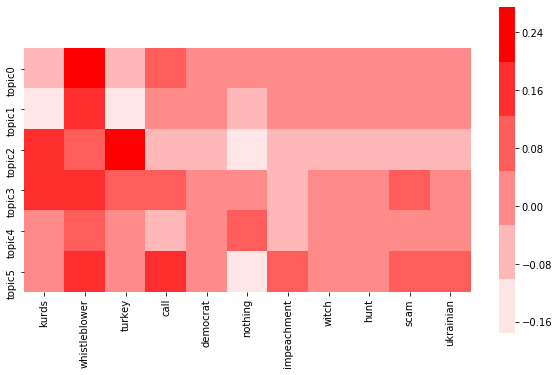

In [256]:
import seaborn as sns

cmap = sns.light_palette("red")

fig, ax = plt.subplots(figsize=(10,6)) 
ax = sns.heatmap(search_weights, square=True, ax=ax, cmap=cmap)

# fix for mpl bug that cuts off top/bottom of seaborn viz
# taken from https://github.com/mwaskom/seaborn/issues/1773
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show() # ta-da!